In [14]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

metric_files = {
    "base_qrl": "/home/hkppp/Classes/naht/naht_results/mpe-pp/open_train/poam-qrl_open_baselines/sacred/poam_baseline_seed=112358_11-29-03-34-29/1/metrics.json",
    "mod_qrl": "/home/hkppp/Classes/naht/naht_results/mpe-pp/open_train/poam-qrl_open/sacred/poam_baseline_seed=112358_12-02-02-56-04/1/metrics.json", # modified qrl run
}
    


all_runs = {}

for label, path_str in metric_files.items():
    path = Path(path_str)
    with path.open() as f:
        metrics = json.load(f)
    all_runs[label] = metrics

all_runs.keys()

dict_keys(['base_qrl', 'mod_qrl'])

In [15]:
def plot_metric_across_runs(metric_name, runs_dict):
    """
    Plot one metric across multiple runs on the same graph.
    
    runs_dict: {run_label: metrics_dict}
    """
    plt.figure()
    
    found_any = False
    
    for run_label, metrics in runs_dict.items():
        if metric_name not in metrics:
            continue  # this run doesn't have that metric
        
        series = metrics[metric_name]
        steps = series["steps"]
        values = series["values"]
        
        plt.plot(steps, values, marker="o", label=run_label)
        found_any = True
    
    if not found_any:
        print(f"No run contains metric '{metric_name}'")
        plt.close()
        return
    
    plt.xlabel("Steps")
    plt.ylabel(metric_name)
    plt.title(metric_name)
    plt.grid(True)
    plt.legend()
    plt.show()

In [16]:
# Collect all metric names that appear in any run
all_metric_names = set()
for metrics in all_runs.values():
    all_metric_names.update(metrics.keys())

sorted(all_metric_names)


['actor_grad_norm',
 'actor_loss',
 'advantage_mean',
 'critic_grad_norm',
 'critic_loss',
 'curr_taken_v',
 'ed_act_loss',
 'ed_grad_norm',
 'ed_loss',
 'ed_obs_loss',
 'entropy',
 'episode',
 'log_pi_taken',
 'old_values_mean',
 'ratio',
 'target_mean',
 'td_error_abs',
 'test_ep_length_mean',
 'test_return_mean',
 'test_return_std',
 'train_ep_length_mean',
 'train_return_mean',
 'train_return_std']

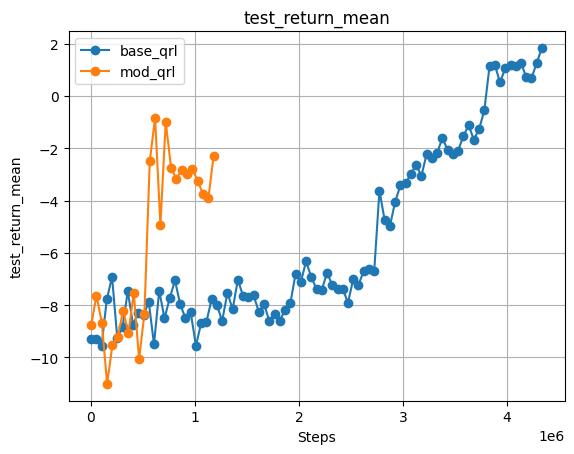

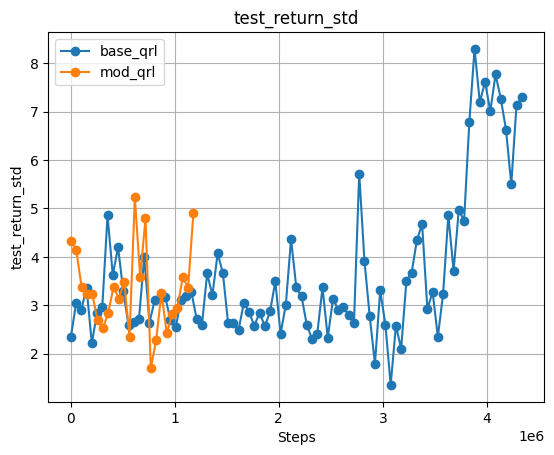

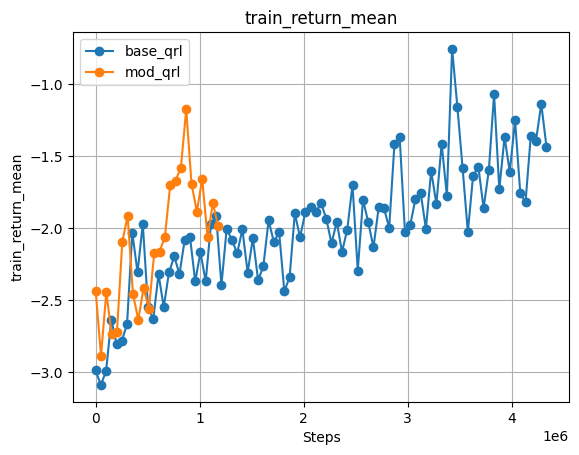

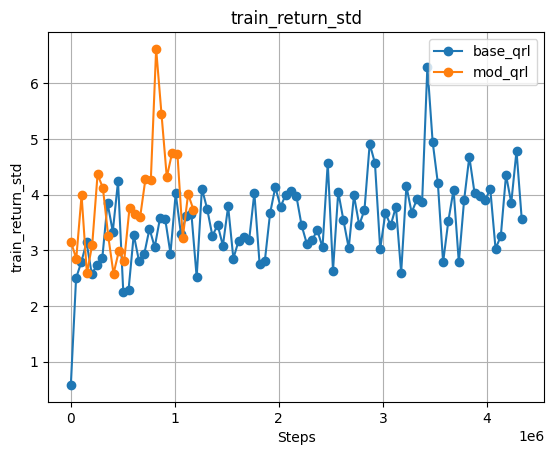

In [17]:
# Plot each metric across runs
selected_metric_names = ['test_return_mean', 'test_return_std', 'train_return_mean', 'train_return_std']
for metric_name in sorted(selected_metric_names):
    plot_metric_across_runs(metric_name, all_runs)
